# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 29 kB/s s eta 0:00:01    |████████████▋                   | 12.2 MB 1.3 MB/s eta 0:00:15     |██████████████▊                 | 14.2 MB 1.3 MB/s eta 0:00:13     |█████████████████               | 16.4 MB 1.3 MB/s eta 0:00:12B 15.9 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import catboost as cb
import time
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

data=pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Для определения средней цены нет необходимости в данных: дата скачивания анкеты из базы, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя, удаляем эти столбцы.

In [3]:
data=data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen','RegistrationMonth'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [4]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [5]:
data.describe()

,price,registration_year,power,kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


<AxesSubplot:>

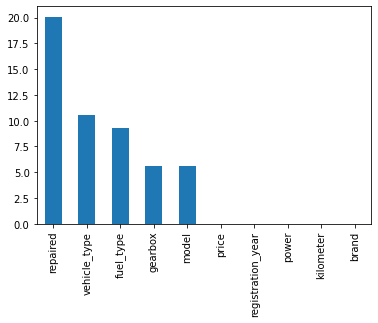

In [6]:
(data.isna().sum().sort_values(ascending=False) / data.shape[0] * 100).plot(kind='bar')

Посмотрим на значения в столбце "Repaired"

In [7]:
data.repaired.unique()

array([nan, 'yes', 'no'], dtype=object)

In [8]:
data.repaired.isna().sum()

71154

Эти данные лучше заполнить N/A, чем потерять 71154 строк остального массива данных

In [9]:
data.fillna({'repaired':'yes'}, inplace=True)

Проверяем

In [10]:
data.repaired.unique()

array(['yes', 'no'], dtype=object)

In [11]:
data.loc[(data.repaired == 'yes'), 'repaired'] = 1
data.loc[(data.repaired == 'no'), 'repaired'] = 0

In [12]:
data.repaired = data.repaired.astype('int')

Посмотрим на значения в столбце "VehicleType"

In [13]:
data.vehicle_type.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [14]:
data.vehicle_type.isna().sum()

37490

Заполним N/A по аналогии со столбцом Repaired 

In [15]:
data['vehicle_type']=data['vehicle_type'].fillna('other')

In [16]:
data.vehicle_type.unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

Посмотрим на значения в столбце "FuelType"

In [18]:
data.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [19]:
data.fuel_type.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [20]:
data.fuel_type.isna().sum()

32895

Тут за отсутсвием данных о виде топлива, но при наличии значения other заполним им пропуски

In [21]:
data['fuel_type']=data['fuel_type'].fillna('other')

In [22]:
data.fuel_type.value_counts()

petrol      216352
gasoline     98720
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: fuel_type, dtype: int64

In [23]:
data.fuel_type.unique()

array(['petrol', 'gasoline', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

Посмотрим на значения в столбце "Gearbox"

In [24]:
data.query('gearbox.isna()')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,1
16,300,other,2016,NaN,60,polo,150000,petrol,volkswagen,1
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,0
37,1500,other,2016,NaN,0,kangoo,150000,gasoline,renault,0
40,0,other,1990,NaN,0,corsa,150000,petrol,opel,1
...,...,...,...,...,...,...,...,...,...,...
354288,3300,wagon,2006,NaN,0,touran,150000,gasoline,volkswagen,1
354305,3500,other,1995,NaN,0,polo,150000,other,volkswagen,1
354329,350,small,1996,NaN,65,punto,150000,other,fiat,1
354338,180,other,1995,NaN,0,NaN,125000,petrol,opel,1


Информация о корбкe передач достаточно важный параметр, который сильно может повлиять на модель при обучении. В связи с этим лучше избавиться от этих данных во избежании лишнего "шума", чем заполнить пропуски каким-то значением. К тому же по данным строкам есть множество ошибочных значений и пропусков в других столбцах

In [25]:
data.dropna(subset=['gearbox'], inplace=True)

In [26]:
data.gearbox.unique()

array(['manual', 'auto'], dtype=object)

In [27]:
#заменяю в gearbox значение manual на 1, auto - на 0:
data.loc[(data.gearbox == 'manual'), 'gearbox'] = 1   
data.loc[(data.gearbox == 'auto'), 'gearbox'] = 0

In [28]:
data.gearbox = data.gearbox.astype('int')

Просмотрим пропущенные значения по столбцу "Model"

In [29]:
data.query('model.isna()')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,1,190,NaN,125000,gasoline,audi,1
59,1,suv,1994,1,286,NaN,150000,other,sonstige_autos,1
81,350,small,1997,1,54,NaN,150000,other,fiat,1
135,1450,sedan,1992,1,136,NaN,150000,other,audi,0
160,500,small,1999,1,0,NaN,150000,petrol,renault,0
...,...,...,...,...,...,...,...,...,...,...
354080,4300,small,2008,0,0,NaN,150000,other,honda,1
354234,5000,sedan,2002,0,170,NaN,150000,petrol,audi,0
354245,560,small,2001,0,170,NaN,90000,petrol,fiat,1
354321,9400,wagon,2007,1,200,NaN,150000,gasoline,sonstige_autos,1


Модель - это основопологающий фактор, который на прямую воздействует на образование цены и заменить его на что-либо другое будет неправильно, удалим отсутствующие значения из наших данных

In [30]:
data['model']=data['model'].fillna('other')

Посмотрим на целевой столбец Price с ценой автомобилей

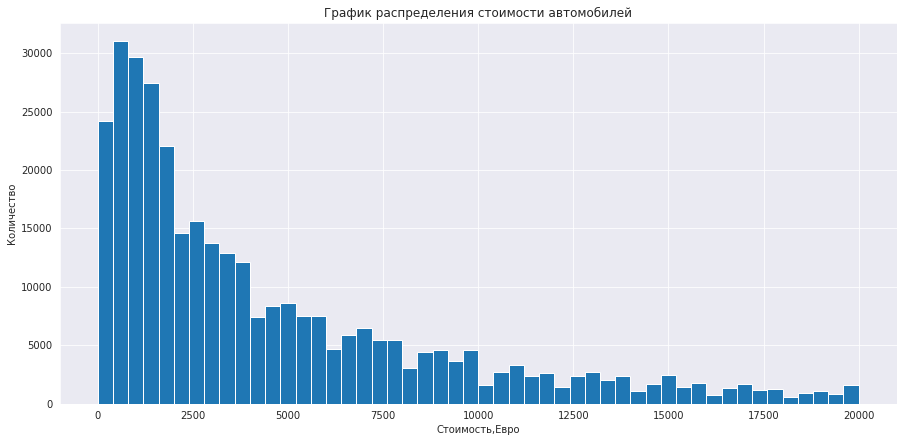

In [32]:
sns.set_style('darkgrid')
data.price.hist(bins=50,figsize=(15,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

In [33]:
data.loc[data['price'] < 50]['price'].count()

9254

Удалим данные стоимости автомобилей 

In [35]:
data = data.query('price > 50')

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325072 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              325072 non-null  int64 
 1   vehicle_type       325072 non-null  object
 2   registration_year  325072 non-null  int64 
 3   gearbox            325072 non-null  int64 
 4   power              325072 non-null  int64 
 5   model              325072 non-null  object
 6   kilometer          325072 non-null  int64 
 7   fuel_type          325072 non-null  object
 8   brand              325072 non-null  object
 9   repaired           325072 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 27.3+ MB


Проверим столбец "RegistrationYear" на уникальные значения

In [38]:
data.registration_year.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2007, 2009,
       2002, 2018, 1997, 1990, 2017, 1981, 2003, 2016, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1994, 1996, 1989, 2015, 1985,
       1982, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986, 1976, 1965,
       1970, 1945, 1974, 1979, 1955, 1978, 1972, 1977, 1961, 1966, 1975,
       1968, 1963, 1964, 1958, 1967, 1956, 1941, 1960, 1500, 1962, 1929,
       1957, 1910, 1940, 2019, 1937, 1951, 1953, 1954, 1959, 2900, 6000,
       5911, 1400, 1950, 4000, 1948, 1000, 1932, 1952, 3700, 5000, 4800,
       1942, 1935, 1923, 1930, 1943, 1938, 1934, 1936, 1928, 2800, 1931,
       4500, 1602, 1927, 7100, 1933, 8200, 1947, 1946, 1944, 1600])

2017 и 2018 года могут быть опечаткой и близки к 2016, поэтому чтоб не потерять данные заменяем их на 2016

In [39]:
data=data.replace({'registration_year' : { 2017 : 2016, 2018 : 2016}})

In [40]:
data.registration_year.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2007, 2009,
       2002, 2016, 1997, 1990, 1981, 2003, 1991, 1984, 2006, 1999, 2012,
       2010, 2000, 1992, 2013, 1994, 1996, 1989, 2015, 1985, 1982, 1983,
       1973, 1969, 1971, 1987, 1988, 1980, 1986, 1976, 1965, 1970, 1945,
       1974, 1979, 1955, 1978, 1972, 1977, 1961, 1966, 1975, 1968, 1963,
       1964, 1958, 1967, 1956, 1941, 1960, 1500, 1962, 1929, 1957, 1910,
       1940, 2019, 1937, 1951, 1953, 1954, 1959, 2900, 6000, 5911, 1400,
       1950, 4000, 1948, 1000, 1932, 1952, 3700, 5000, 4800, 1942, 1935,
       1923, 1930, 1943, 1938, 1934, 1936, 1928, 2800, 1931, 4500, 1602,
       1927, 7100, 1933, 8200, 1947, 1946, 1944, 1600])

In [41]:
data=data.query('1950 <=registration_year <=2016')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324968 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              324968 non-null  int64 
 1   vehicle_type       324968 non-null  object
 2   registration_year  324968 non-null  int64 
 3   gearbox            324968 non-null  int64 
 4   power              324968 non-null  int64 
 5   model              324968 non-null  object
 6   kilometer          324968 non-null  int64 
 7   fuel_type          324968 non-null  object
 8   brand              324968 non-null  object
 9   repaired           324968 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 27.3+ MB


Посмотрим на значения в столбце "Power"

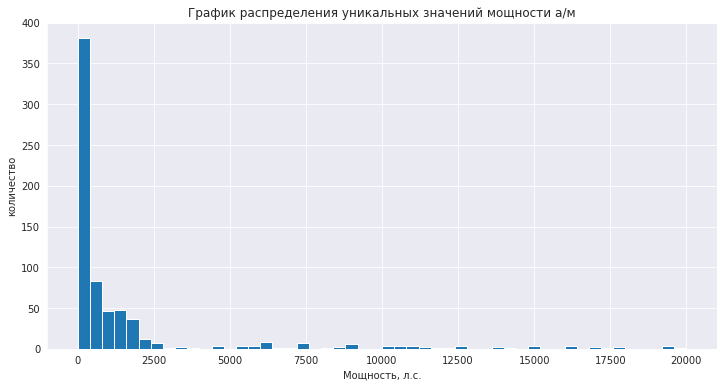

In [43]:
pd.Series(list(data.power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

Удалим данные о мощности дигателя свыше 5000 л.с. и менее 15 л.с.

In [44]:
data['power'] = data['power'].replace({'0':np.nan, 0:np.nan})

In [45]:
data['power']= data['power']. fillna(data['power'].mean())

In [46]:
data['power'].unique()

array([1.24413417e+02, 1.90000000e+02, 1.63000000e+02, 7.50000000e+01,
       6.90000000e+01, 1.02000000e+02, 1.09000000e+02, 1.25000000e+02,
       1.01000000e+02, 1.05000000e+02, 1.40000000e+02, 1.15000000e+02,
       1.31000000e+02, 1.36000000e+02, 1.60000000e+02, 2.31000000e+02,
       9.00000000e+01, 5.00000000e+01, 1.18000000e+02, 1.93000000e+02,
       9.90000000e+01, 6.00000000e+01, 1.13000000e+02, 2.18000000e+02,
       1.22000000e+02, 1.29000000e+02, 7.00000000e+01, 3.06000000e+02,
       9.50000000e+01, 6.10000000e+01, 1.77000000e+02, 8.00000000e+01,
       1.70000000e+02, 5.50000000e+01, 1.43000000e+02, 6.40000000e+01,
       2.32000000e+02, 1.50000000e+02, 1.56000000e+02, 8.20000000e+01,
       1.55000000e+02, 5.40000000e+01, 1.85000000e+02, 8.70000000e+01,
       1.80000000e+02, 8.60000000e+01, 8.40000000e+01, 2.24000000e+02,
       2.35000000e+02, 2.00000000e+02, 1.78000000e+02, 2.65000000e+02,
       7.70000000e+01, 1.10000000e+02, 1.44000000e+02, 1.20000000e+02,
      

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324968 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              324968 non-null  int64  
 1   vehicle_type       324968 non-null  object 
 2   registration_year  324968 non-null  int64  
 3   gearbox            324968 non-null  int64  
 4   power              324968 non-null  float64
 5   model              324968 non-null  object 
 6   kilometer          324968 non-null  int64  
 7   fuel_type          324968 non-null  object 
 8   brand              324968 non-null  object 
 9   repaired           324968 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 27.3+ MB


Данные изучены, пропуски заполнены. 

Сбросим индексы, после удаления лишних значений

In [48]:
data=data.reset_index(drop=True)

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Названия столбцов можно записать в snake_case

In [49]:
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,1,124.413417,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,1,190.000000,other,125000,gasoline,audi,1
2,9800,suv,2004,0,163.000000,grand,125000,gasoline,jeep,1
3,1500,small,2001,1,75.000000,golf,150000,petrol,volkswagen,0
4,3600,small,2008,1,69.000000,fabia,90000,gasoline,skoda,0
...,...,...,...,...,...,...,...,...,...,...
324963,3200,sedan,2004,1,225.000000,leon,150000,petrol,seat,1
324964,1150,bus,2000,1,124.413417,zafira,150000,petrol,opel,0
324965,1199,convertible,2000,0,101.000000,fortwo,125000,petrol,smart,0
324966,9200,bus,1996,1,102.000000,transporter,150000,gasoline,volkswagen,0


Разделим данные на основную выборку и целевые признаки

In [50]:
category_features = ['vehicle_type', 'gearbox', 'brand', 'model', 'fuel_type']

In [51]:
number_features = ['registration_year', 'power', 'kilometer', 'repaired']

In [52]:
data = data[number_features + category_features + ['price']];
data_simple = data.copy()
data_simple.head()

,registration_year,power,kilometer,repaired,vehicle_type,gearbox,brand,model,fuel_type,price
0,1993,124.413417,150000,1,other,1,volkswagen,golf,petrol,480
1,2011,190.000000,125000,1,coupe,1,audi,other,gasoline,18300
2,2004,163.000000,125000,1,suv,0,jeep,grand,gasoline,9800
3,2001,75.000000,150000,0,small,1,volkswagen,golf,petrol,1500
4,2008,69.000000,90000,0,small,1,skoda,fabia,gasoline,3600


In [53]:
features = data_simple.drop(columns='price')
target = data_simple['price']

In [54]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [55]:
ohe_features_ridge= features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

#категориальные признаки для OHE RandomForestRegressor
ohe_features_rf = ohe_features_ridge.copy()
ohe_features_rf.remove('model')
ohe_features_rf

['vehicle_type', 'brand', 'model', 'fuel_type']


['vehicle_type', 'brand', 'fuel_type']

In [56]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('repaired')
num_features

['registration_year', 'power', 'kilometer', 'gearbox']

In [57]:
features_train_ridge = features_train.copy()
features_test_ridge = features_test.copy()

Проведем масштабирование

In [58]:
def encode_features(data, encoder, ohe_features_ridge):
    array_encoded = encoder.transform(data.loc[:, ohe_features_ridge])
    
    # перезапишем значения признаков в исходном наборе данных
    data_encoded = pd.DataFrame(array_encoded, 
                                columns=encoder.get_feature_names(ohe_features_ridge),
                                index=data.index)
    data = pd.concat([data, data_encoded], axis=1)
    # удалим "лишние" признаки
    data.drop(labels=ohe_features_ridge, axis=1, inplace=True)
    
    return data

In [59]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(features_train_ridge.loc[:, ohe_features_ridge])
features_train_ridge = encode_features(features_train_ridge, encoder, ohe_features_ridge)
features_test_ridge = encode_features(features_test_ridge, encoder, ohe_features_ridge)
scaler = StandardScaler()
scaler.fit(features_train_ridge[num_features])
features_train_ridge[num_features] = scaler.transform(features_train_ridge[num_features])
features_test_ridge[num_features] = scaler.transform(features_test_ridge[num_features])
features_train_ridge.head()

,registration_year,power,kilometer,repaired,gearbox,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,model_ypsilon,model_z_reihe,model_zafira,fuel_type_cng,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol
118582,-1.615927,-0.457893,0.578633,1,0.499576,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18689,1.846914,0.001124,0.578633,1,0.499576,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
85218,0.548348,0.969790,-0.103719,0,-2.001699,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
195402,-0.028792,0.149017,0.578633,0,0.499576,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67074,0.259778,0.287739,0.578633,1,0.499576,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [60]:
features_test_ridge.head()

,registration_year,power,kilometer,repaired,gearbox,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,model_ypsilon,model_z_reihe,model_zafira,fuel_type_cng,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol
101599,0.115493,-0.382752,-0.103719,0,0.499576,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
260662,0.548348,0.305079,0.578633,0,-2.001699,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40301,-0.894502,-0.134208,0.578633,1,0.499576,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
131110,0.548348,0.224158,0.578633,0,0.499576,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
243844,0.115493,-0.382752,0.578633,0,0.499576,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Проверим размеры выборок:

In [61]:
print(features_train_ridge.shape)
print(features_test_ridge.shape)

(243726, 310)
(81242, 310)


Данные готовы к обучению модели.

## Обучение моделей

Обучим разные модели. Для каждой укажем оптимальные гиперпараметры и поставим счётчик времени выполнения операций.

Для расчёта целевой метрики используем RMSE и напишем функцию.

In [62]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)

LinearRegression

In [63]:
%%time
start = time.time()
model_lr=LinearRegression()
model_lr.fit(features_train_ridge,target_train)
end = time.time()
t_lr=round(end-start,2)
print('Время обучения модели, c', t_lr)

Время обучения модели, c 110.78
CPU times: user 50 s, sys: 59.1 s, total: 1min 49s
Wall time: 1min 50s


In [64]:
%%time
start = time.time()
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(model_lr,features_train_ridge,target_train,scoring=RMSE_score,cv=3)).mean()*(-1)
end = time.time()
t_rvs=round(end-start,2)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)
print(t_rvs)


Среднее качество модели линейной регрессии на кросс-валидации: 17326055455.05615
212.95
CPU times: user 1min 36s, sys: 1min 55s, total: 3min 31s
Wall time: 3min 32s


In [65]:

%%time
start = time.time()
target_predict = model_lr.predict(features_train_ridge) 
end = time.time()
t_lrp=round(end-start,2)
print('Время предсказания, c', t_lrp)


Время предсказания, c 0.48
CPU times: user 265 ms, sys: 180 ms, total: 444 ms
Wall time: 485 ms


Обучаем лес решений:

In [ ]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100)
#pipline_rf = make_pipeline(col_transformer_rf, model_rf)
model_rf.fit(features_train_ridge, target_train)
end = time.time()
t_rf=round(end-start,2)
print('Время обучения модели, с', t_rf)

In [ ]:
%%time
#Объявляю модель
forest = RandomForestRegressor()
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 15, 5),
                     'max_depth': range(1, 6, 2),
                     'min_samples_leaf': range(1,4),
                     'min_samples_split': range(2,6,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=3)
forest_grid.fit(features_train_ridge, target_train)
fbs=forest_grid.best_score_*(-1)
print(forest_grid.best_estimator_)
print(forest_grid.best_params_)
print('Качество модели на кросс-валидации', fbs)

In [ ]:

%%time
start = time.time()
target_predict_forest= model_rf.predict(features_train_ridge) 
end = time.time()
t_tpf=round(end-start,2)
print('Время предсказания', t_tpf)

Обучаем ансамбль моделей CatBoostRegressor

In [ ]:
%%time
model_cat = CatBoostRegressor(loss_function='RMSE',silent=True, cat_features=category_features, random_seed=12345)
start = time.time()
model_cat.fit(features_train, target_train)
end = time.time()
t_cat=round(end-start,2)
print('Время обучения модели, с', t_cat)

In [ ]:
%%time
start=time.time()

cbr = CatBoostRegressor(loss_function='RMSE',silent=True, cat_features=category_features, random_seed=12345)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_squared_error')
grid_cbr.fit(features_train, target_train);
cbs=grid_cbr.best_score_*(-1)
print(forest_grid.best_estimator_)
print(forest_grid.best_params_)
print('Качество модели на кросс-валидации', cbs)




In [ ]:

%%time
start = time.time()
target_predict_cbr= model_cat.predict(features_train) 
end = time.time()
cbr_pd=round(end-start,2)
print('Время предсказания модели, с', cbr_pd)

Обучаем ансамбль моделей LGBMRegressor:

Для категориальных признаков LightGBM будем использовать внутренний алгоритм кодирования

In [ ]:
# Для GBM дополнительно обработаем категориальные признаки

features_train_gbm = features_train.copy()
features_test_gbm = features_test.copy()

cat_features = features_train_gbm.select_dtypes(include=np.object).columns.tolist() 
features_train_gbm[cat_features] = features_train_gbm[cat_features].astype('category')
features_test_gbm[cat_features] = features_test_gbm[cat_features].astype('category')


features_train_gbm.head()

In [ ]:
%%time
start = time.time()
model_LGB = lgb.LGBMRegressor()
model_LGB.fit(features_train_gbm, target_train, verbose=100, categorical_feature=cat_features)
end = time.time()
t_lgb=round(end-start,2)
print('Время обучения модели', t_lgb)

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [ ]:
%%time
#Объявляю модель
lg = lgb.LGBMRegressor()
#Определяю словарь с набором параметров
lg_parametrs = {"max_depth": [5,7,10], "learning_rate" : [0.01, 0.1], "num_leaves": [127],"n_estimators": range (5,10,2)}
#Применяю GridSearchCV с кросс-валидацией
lg_grid = GridSearchCV(lg, lg_parametrs, scoring=RMSE_score, cv=3, verbose=True)
lg_grid.fit(features_train_gbm, target_train)
lbs=lg_grid.best_score_*(-1)
print(lg_grid.best_estimator_)
print(lg_grid.best_params_)
print('Качество модели на кросс-валидации', lbs)

In [ ]:

%%time
start = time.time()
target_predict_lgr= model_LGB.predict(features_train_gbm) 
end = time.time()
lgr_pd=round(end-start,2)
print('Время предсказания модели, с', cbr_pd)

# Вывод

По времени предсказания лучше всех себя показала модель LightGBM	

## Анализ моделей

Константная модель:

In [ ]:
%%time
#Для проверки адекватности моделей создаю константную модель
const_model = pd.Series(target_test.median(), index=target_test.index)

#Определяю метрику RMSE константной модели
const_RMSE = round(RMSE(target_test, const_model), 3)
print('RMSE для константной модели', const_RMSE)

In [ ]:
column=['Качество модели','Скорость обучения, s','Скорость предсказания, s','Рейтинг']

comparison_tabl = pd.DataFrame(index=['Качество модели','Скорость обучения, s','Скорость предсказания, s','Рейтинг'], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor','LightGBM'])
comparison_tabl['LinearRegression'] = regression_cv_score, t_lr, t_lrp,(regression_cv_score/const_RMSE)*100
comparison_tabl['RandomForestRegressor'] = fbs, t_rf, t_tpf,(fbs/const_RMSE)*100
comparison_tabl['CatBoostRegressor'] = cbs, t_cat, cbr_pd, (cbs/const_RMSE)*100
comparison_tabl['LightGBM'] = lbs,t_lgb,lgr_pd,  (lbs/const_RMSE)*100
comparison_tabl

Исходя из данных таблицы лучшей моделью признаем LightGBM, хоть у нее чуть хуже качество, но выше скорость предсказния

Прверяем на тестовой выборке Модель ансамбля решений LGBMRegressor:

In [ ]:
%%time  
#model_LGB_t = lgb.LGBMRegressor(predict_disable_shape_check=True)
target_predict=model_LGB.predict(features_test_gbm)
   
    
    

In [ ]:
print('RMSE',round(mean_squared_error(target_test, target_predict) ** 0.5,2))

Оценим вжность факторов в модели

# Общий вывод

Перед нами стояла задача- построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

Мы использовали технологию градиетного бустинга в моделях CatBoostRegressor и LightGBM, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor

По итогам качества и скорости обучения побеждает модель LightGBM.



## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей

Привет! Очень сильно тормозил Юпитер, приршлось чуть переделывать работу. 